# FTS Cameroun — Projet ML end‑to‑end

Objectifs : prédire le **taux de financement** (ou l'**écart de financement**) par *cluster* pour l'année suivante.

Ce notebook couvre : EDA → feature engineering → split temporel → entraînement → validation walk‑forward → interprétation → export modèle.

In [2]:
# 1) Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['figure.figsize'] = (9, 5)

### Voyons comment se présentent les données en question:

On va charger et afficher les données (juste un aperçu)

In [3]:
# 2) Chargement dans un dataframe
DATA_PATH = Path('fts_requirements_funding_globalcluster_cmr.csv')
df = pd.read_csv(DATA_PATH)

df.head(10)


,countryCode,id,name,code,startDate,endDate,year,clusterCode,cluster,requirements,funding,percentFunded
0,#country+code,#activity+appeal+id+fts_internal,#activity+appeal+name,#activity+appeal+id+external,#date+start,#date+end,#date+year,#sector+cluster+code,#sector+cluster+name,#value+funding+required+usd,#value+funding+total+usd,#value+funding+pct
1,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,26480,Coordination and support services,14048886,4171999,30
2,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,3,Education,20470965,987300,5
3,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,4,Emergency Shelter and NFI,22124343,3619051,16
4,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,6,Food Security,92803509,10015469,11
5,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,7,Health,27716414,4108451,15
6,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,26479,Multi-sector,89889762,5484710,6
7,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,16,Multipurpose Cash,3984186,1692395,42
8,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,9,Nutrition,28062243,3852990,14
9,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,26481,Other,NaN,1580922,NaN


In [4]:
# La liste des colonnes

df.columns

Index(['countryCode', 'id', 'name', 'code', 'startDate', 'endDate', 'year',
       'clusterCode', 'cluster', 'requirements', 'funding', 'percentFunded'],
      dtype='object')

Revelons un peu plus de détails à propos de notre jeu de données

In [5]:
df.describe()

,countryCode,id,name,code,startDate,endDate,year,clusterCode,cluster,requirements,funding,percentFunded
count,180,180,180,180,180,180,180,156,180,147,169,135
unique,2,13,13,13,13,13,13,22,24,145,162,69
top,CMR,1080,Cameroon Humanitarian Response Plan 2022,HCMR22,2022-01-01,2022-12-31,2022,3,Multiple clusters/sectors (shared),56000,0,22
freq,179,20,20,20,20,20,20,12,12,2,8,6


#### Essayons d'y voir un peu clair
C'est très différent de ce que j'ai l'habitude de voir avec les datasets de Kaggle. Au 1er coup d'oeil, on constate que les stats descriptives ne veulent rien dire (en tout cas, perso je n'y comprend rien). On peut demander d'autres informations avec info().


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   countryCode    180 non-null    object
 1   id             180 non-null    object
 2   name           180 non-null    object
 3   code           180 non-null    object
 4   startDate      180 non-null    object
 5   endDate        180 non-null    object
 6   year           180 non-null    object
 7   clusterCode    156 non-null    object
 8   cluster        180 non-null    object
 9   requirements   147 non-null    object
 10  funding        169 non-null    object
 11  percentFunded  135 non-null    object
dtypes: object(12)
memory usage: 17.0+ KB


On peut maintenant voir que les colonnes sont toutes de dtype ```object```. Pourtant il est évident que les colonnes comme ```requirements```, ```funding``` ou encore ```percentFunded``` devraient être numériques.
Quelque chose s'est peut-être passé lors de la lecture du fichier, qui a fait croire que ces colonnes sont non-numériques. Je suspecte surtout la ligne 0 

Je sens qu'on aura du pain sur la planche...

In [7]:
# On va recharger en ignorant la 1ere ligne (la ligne d'après les en-têtes, sinon on perdra le nom des colonnes)

df = pd.read_csv(DATA_PATH, skiprows=[1])

df.head(3)

,countryCode,id,name,code,startDate,endDate,year,clusterCode,cluster,requirements,funding,percentFunded
0,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,26480.0,Coordination and support services,14048886.0,4171999.0,30.0
1,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,3.0,Education,20470965.0,987300.0,5.0
2,CMR,1266,Cameroon Humanitarian Response Plan 2025,HCMR25,2025-01-01,2025-12-31,2025,4.0,Emergency Shelter and NFI,22124343.0,3619051.0,16.0


C'est bon, elle n'est plus là!

In [8]:
# Voilà maintenant regardons si ca donne les vrais dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    179 non-null    object 
 1   id             179 non-null    int64  
 2   name           179 non-null    object 
 3   code           179 non-null    object 
 4   startDate      179 non-null    object 
 5   endDate        179 non-null    object 
 6   year           179 non-null    int64  
 7   clusterCode    155 non-null    float64
 8   cluster        179 non-null    object 
 9   requirements   146 non-null    float64
 10  funding        168 non-null    float64
 11  percentFunded  134 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 16.9+ KB


**Cool!** Que donnent maintenant les statistiques descriptives..

In [9]:
df.describe()

,id,year,clusterCode,requirements,funding,percentFunded
count,179.000000,179.000000,155.000000,1.460000e+02,1.680000e+02,134.000000
mean,867.536313,2020.016760,6500.193548,2.565100e+07,1.023233e+07,37.798507
std,285.856573,3.347773,11429.112615,2.933145e+07,1.380249e+07,27.006204
min,446.000000,2014.000000,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,537.000000,2017.000000,6.000000,7.121669e+06,1.970040e+06,17.250000
50%,927.000000,2020.000000,10.000000,1.673838e+07,5.657328e+06,30.000000
75%,1115.000000,2023.000000,16.000000,2.843508e+07,1.066579e+07,54.750000
max,1266.000000,2025.000000,26546.000000,1.373544e+08,7.950349e+07,128.000000


Maintenant on va faire un peu de ménage, et ne laisser que les colonnes intéressantes

In [10]:
columns = [
    'year','requirements', 'funding', 'percentFunded', 'cluster' ]

df = df[columns]

df.head()



,year,requirements,funding,percentFunded,cluster
0,2025,14048886.0,4171999.0,30.0,Coordination and support services
1,2025,20470965.0,987300.0,5.0,Education
2,2025,22124343.0,3619051.0,16.0,Emergency Shelter and NFI
3,2025,92803509.0,10015469.0,11.0,Food Security
4,2025,27716414.0,4108451.0,15.0,Health


In [11]:
# Quels sont les différents clusters qu'on a ?
# Enumérons-les
df['cluster'].unique()

array(['Coordination and support services', 'Education',
       'Emergency Shelter and NFI', 'Food Security', 'Health',
       'Multi-sector', 'Multipurpose Cash', 'Nutrition', 'Other',
       'Protection', 'Protection - Child Protection',
       'Protection - Gender-Based Violence',
       'Protection - Housing, Land and Property',
       'Water Sanitation Hygiene', 'Not specified',
       'Multiple clusters/sectors (shared)', 'Agriculture',
       'Camp Coordination / Management', 'Early Recovery', 'Logistics',
       'Protection - Human Trafficking & Smuggling',
       'Protection - Mine Action', 'COVID-19'], dtype=object)

Je vois beaucoup de colonnes 'Protection'. Regardons ca de plus près. Il peut y avoir des liens entre ces clusters (à part le 'Protection' qu'ils ont en commun)

In [12]:
# Afficher les données des clusters 'Protection'
df[df['cluster'].str.contains('Protection')].head(10)

,year,requirements,funding,percentFunded,cluster
9,2025,7224377.0,3345439.0,46.0,Protection
10,2025,13818311.0,1743144.0,13.0,Protection - Child Protection
11,2025,21463852.0,10123323.0,47.0,Protection - Gender-Based Violence
12,2025,1509867.0,18250.0,1.0,"Protection - Housing, Land and Property"
27,2024,23583134.0,14081728.0,60.0,Protection
28,2024,17707023.0,4167888.0,24.0,Protection - Child Protection
29,2024,39410584.0,11060994.0,28.0,Protection - Gender-Based Violence
30,2024,7933513.0,56350.0,1.0,"Protection - Housing, Land and Property"
43,2023,28160396.0,17293215.0,61.0,Protection
44,2023,16318946.0,3728768.0,23.0,Protection - Child Protection


Je ne vois rien qui laisse croire qu'ils ont un lien entre eux à part le nom.
Continuons. Passons aux *valeurs manquantes*

In [13]:
# Colonnes avec des valeurs manquantes

df.isna().sum()

year              0
requirements     33
funding          11
percentFunded    45
cluster           0
dtype: int64

On va voir plus clairement où se trouve les trous, pour pouvoir décider de la meilleure approche à adopter pour les gérer

In [14]:
# Affichons les lignes avec au moins une valeur manquante  
df[df.isna().any(axis=1)].head(15)

,year,requirements,funding,percentFunded,cluster
8,2025,NaN,1580922.0,NaN,Other
14,2025,NaN,2891168.0,NaN,Not specified
15,2025,NaN,5829946.0,NaN,Multiple clusters/sectors (shared)
19,2024,714715.0,NaN,NaN,Early Recovery
26,2024,NaN,796958.0,NaN,Other
32,2024,NaN,762914.0,NaN,Not specified
33,2024,NaN,28356950.0,NaN,Multiple clusters/sectors (shared)
34,2023,67568.0,NaN,NaN,Agriculture
48,2023,NaN,553965.0,NaN,Not specified
49,2023,NaN,3297048.0,NaN,Multiple clusters/sectors (shared)


C'est quoi ce chaos! Ma tête chauffe déjà.. Comment on va décider ce qu'il faut jeter? Ou alors, s'il faut combler les trous, sur quoi va-t-on se baser pour combler.. 
*Un coup d'oeil* un peu attentif nous fera remarquer qu'il y'a une relation entre les trous de chaque ligne: `percentFunded` a une valeur numerique manquante à cause de `requirements` ou `funding`

In [15]:
# Commencons par supprimer toutes les lignes ci-dessus
df.dropna().head(15)

,year,requirements,funding,percentFunded,cluster
0,2025,14048886.0,4171999.0,30.0,Coordination and support services
1,2025,20470965.0,987300.0,5.0,Education
2,2025,22124343.0,3619051.0,16.0,Emergency Shelter and NFI
3,2025,92803509.0,10015469.0,11.0,Food Security
4,2025,27716414.0,4108451.0,15.0,Health
5,2025,89889762.0,5484710.0,6.0,Multi-sector
6,2025,3984186.0,1692395.0,42.0,Multipurpose Cash
7,2025,28062243.0,3852990.0,14.0,Nutrition
9,2025,7224377.0,3345439.0,46.0,Protection
10,2025,13818311.0,1743144.0,13.0,Protection - Child Protection


Maintenant, on va faire de lui le nouveau dataframe

In [16]:
df_0 = df.dropna()


Affichons par exemple toutes les lignes d'un seul cluster, `Education` par exemple..

In [17]:
# Affichons les lignes contenant uniquement le cluster 'Education'
education = df_0.loc[df['cluster'] == 'Education']
education

,year,requirements,funding,percentFunded,cluster
1,2025,20470965.0,987300.0,5.0,Education
20,2024,23922907.0,8538308.0,36.0,Education
37,2023,34581907.0,4020674.0,12.0,Education
53,2022,29239297.0,16645862.0,57.0,Education
74,2021,24981097.0,7205083.0,29.0,Education
91,2020,26928729.0,3955476.0,15.0,Education
105,2019,16445112.0,2858974.0,17.0,Education
118,2018,17158368.0,3017233.0,18.0,Education
134,2017,10407718.0,4069413.0,39.0,Education
148,2016,6272526.0,1739266.0,28.0,Education


#### Analyse du cluster `Education`
On va utiliser des illustrations pour bien voir comment ce cluster a évolué au fil des années

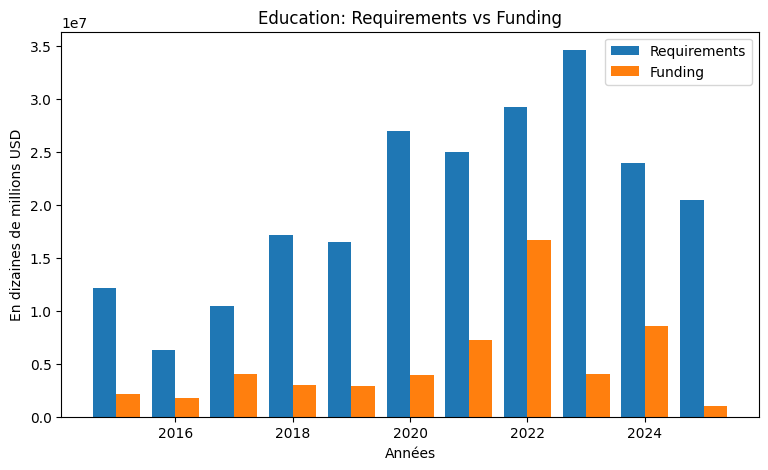

In [26]:
# Courbe graphique en barre qui montre les financements en 'Education' au fil des années
x = education.year
y = education.percentFunded
y1 = education.requirements
y2 = education.funding

# Graphique en barres montrant les 'requirements' et les 'funding' au fil des années
plt.bar(x-0.2, y1, width=0.4, label='Requirements')
plt.bar(x+0.2, y2, width=0.4, label='Funding')
plt.xlabel('Années')
plt.ylabel('En dizaines de millions USD')
plt.title('Education: Requirements vs Funding')
plt.legend()

On va visualiser les autres clusters de la même maniere

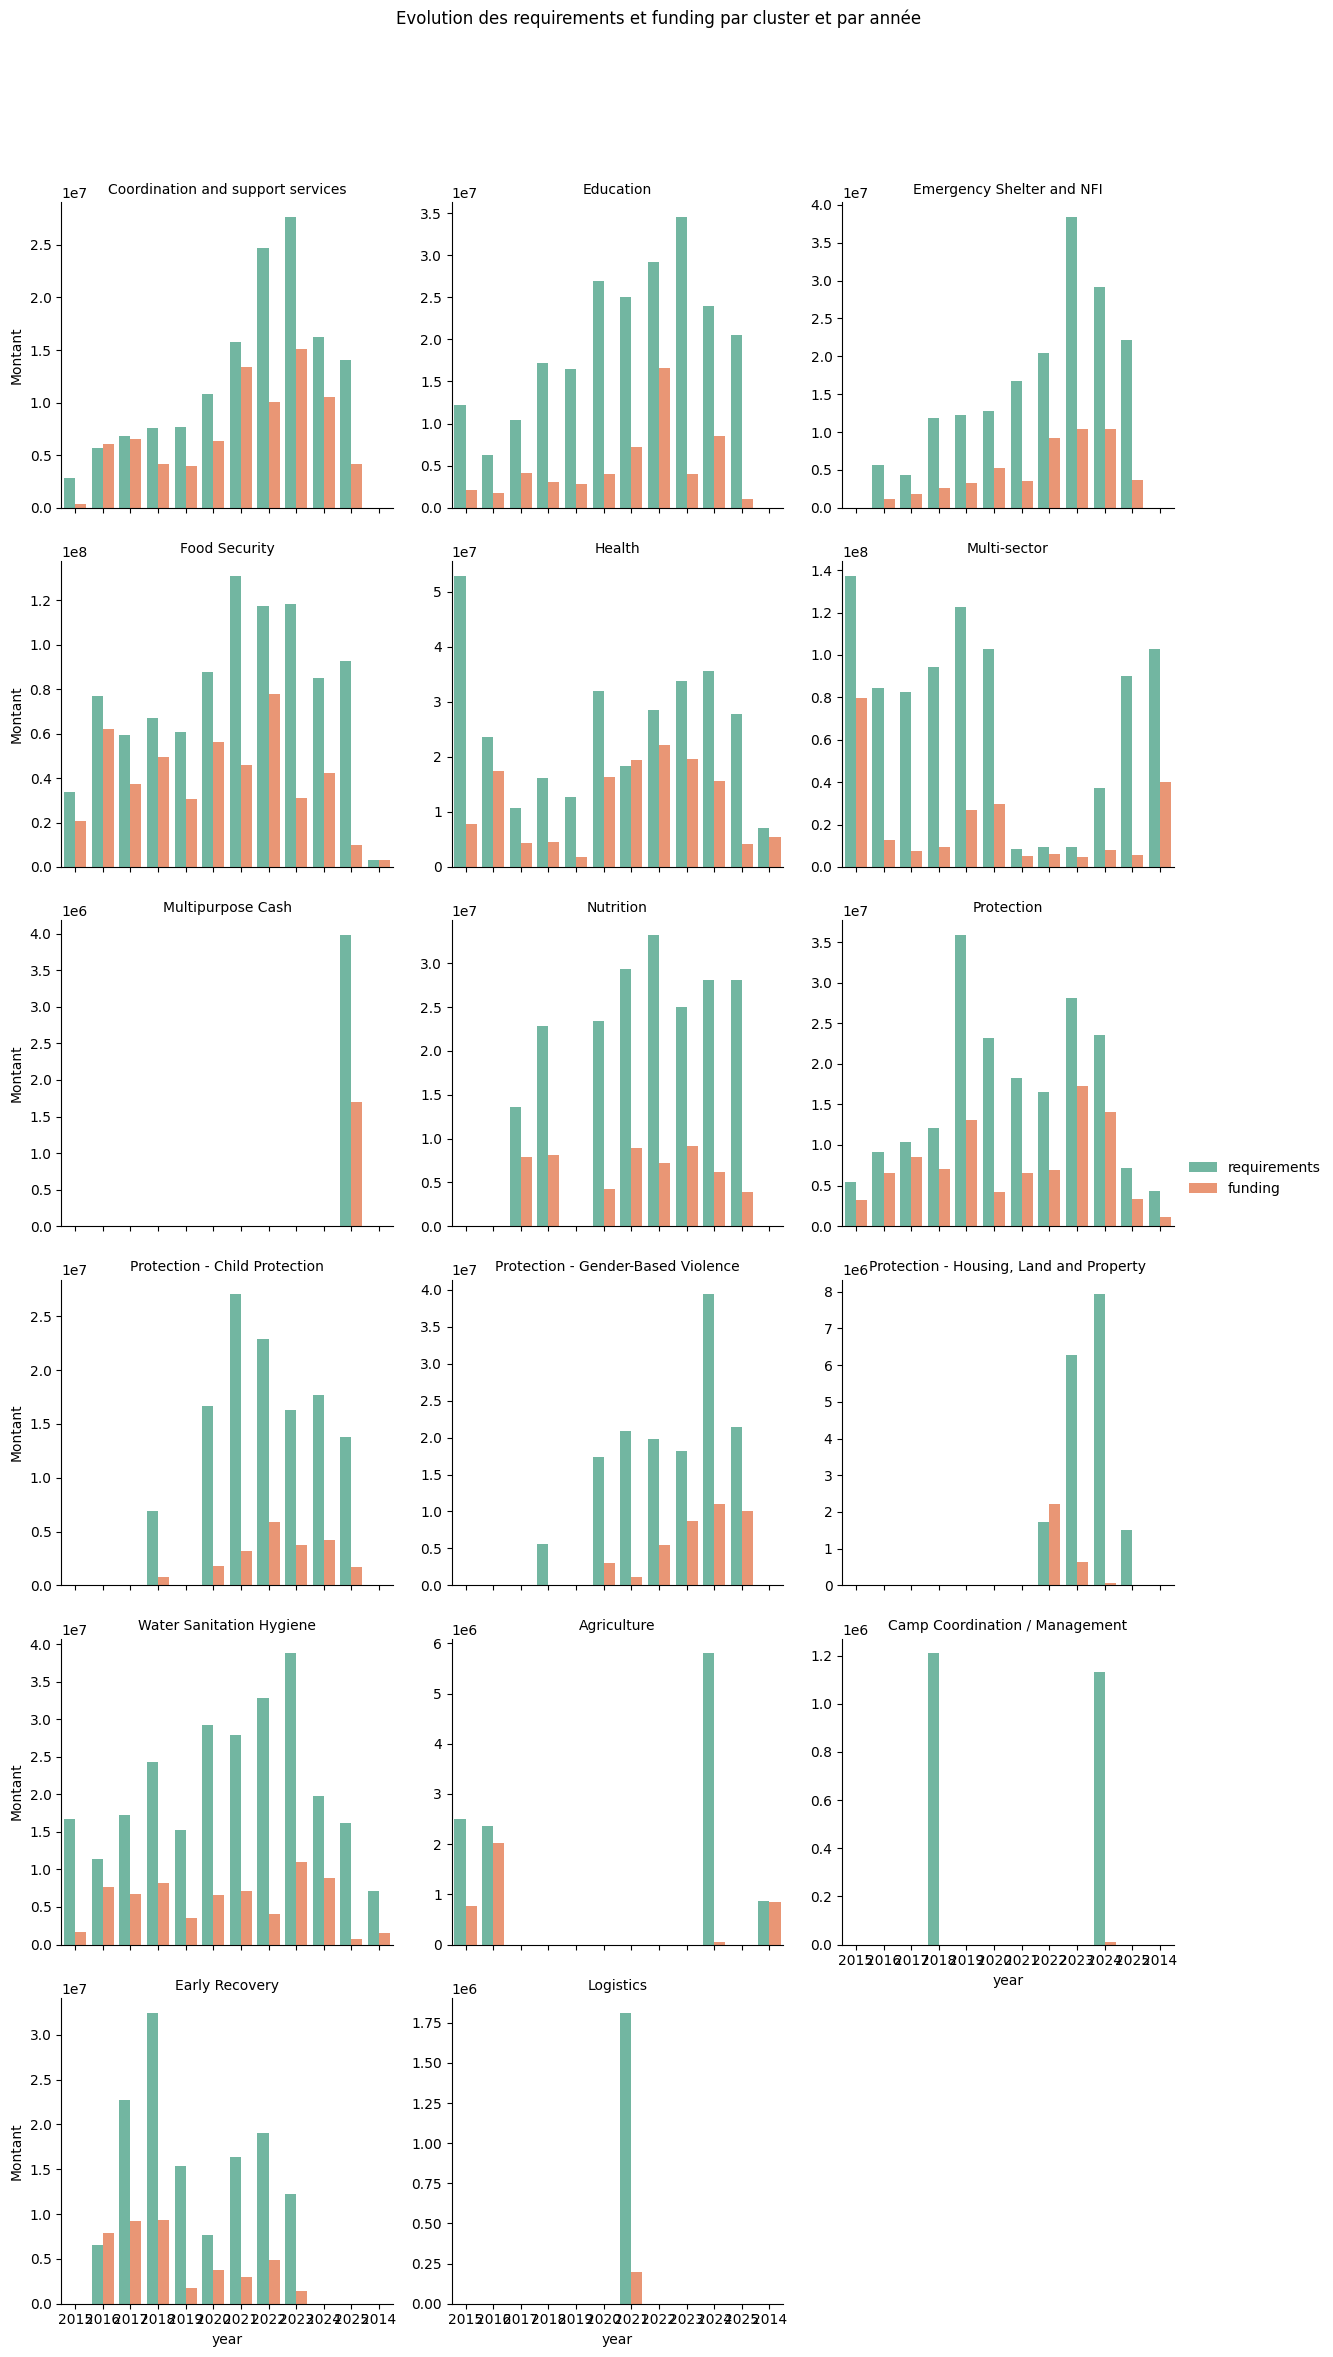

In [33]:

# Préparation des données au format long
df_long = df_0.melt(
    id_vars=['year', 'cluster'],
    value_vars=['requirements', 'funding'],
    var_name='Type',
    value_name='Montant'
)

# FacetGrid : un graphique par cluster
g = sns.FacetGrid(df_long, col="cluster", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="year", y="Montant", hue="Type", palette="Set2")
g.add_legend()
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Evolution des requirements et funding par cluster et par année")
plt.show()